In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
import pandas as pd
from scipy.stats import zscore, norm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm, norm
from scipy.optimize import fmin_slsqp

<Figure size 1500x1000 with 0 Axes>

In [3]:
pca_per_pathway = pd.read_csv('../data/pca_per_pathway.csv', index_col=0)

new_clinical_patient = pd.read_csv('../data/data_clinical_patient.txt', sep='\t', index_col=0).iloc[4:]
new_clinical_sample = pd.read_csv('../data/data_clinical_sample.txt', sep='\t', index_col=0).iloc[4:]
new_clinical = pd.concat([new_clinical_patient, new_clinical_sample.reindex(new_clinical_patient.index)], axis=1)
new_clinical['Triple Neg'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') and (row['PR Status'] == 'Negative') and (row['HER2 Status'] == 'Negative')) else False, axis = 1)
new_clinical['ER-/PR-/HER2+'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') and (row['PR Status'] == 'Negative') and (row['HER2 Status'] == 'Positive')) else False, axis = 1)

full_df = pd.concat([pca_per_pathway, new_clinical.reindex(pca_per_pathway.index)], axis=1)

In [4]:
from scipy.stats import ttest_ind, mannwhitneyu
import qvalue as qv

clusterframes = {}

grouped_by_cluster = full_df.groupby('Integrative Cluster')

for group in grouped_by_cluster:
    df_cluster = pd.DataFrame(index=full_df.iloc[:,:-33].columns)
    groupname = group[0]
    df = group[1].iloc[:,:-33]
    group2_df = full_df[full_df['Integrative Cluster'] != groupname].iloc[:,:-33]
    pvaluelist = []
    group1_mean_list = []
    group2_mean_list = []
    for pathway in df:
        group = df[pathway]
        group2 = group2_df[pathway]
        test = mannwhitneyu(group, group2, alternative='two-sided')
        pvaluelist.append(test[1])
        group_mean = group.mean()
        group1_mean_list.append(group_mean)
        group2_mean = group2.mean()
        group2_mean_list.append(group2_mean) 
        
    
    df_cluster[f'Cluster {groupname}'] = group1_mean_list
    df_cluster['Other clusters'] = group2_mean_list
    df_cluster['Fold Change'] = np.log2(abs(df_cluster[f'Cluster {groupname}'])) - np.log2(abs(df_cluster['Other clusters']))
    
    
    df_cluster['p-values'] = pvaluelist
    qv.qvalues(df_cluster, 'p-values', f'cluster {groupname} qvalues')
    #df_cluster['p-values'] = -np.log10(df_cluster['p-values'])
    #df_cluster[f'cluster {groupname} qvalues'] = -np.log10(df_cluster[f'cluster {groupname} qvalues'])
    print(groupname)
    clusterframes[groupname] = df_cluster
        
        

1
10
2
3
4ER+
4ER-
5
6
7
8
9


quantiles calculated
-4.778888612036237 -0.5716492157712434
Iteration limit exceeded    (Exit mode 9)
            Current function value: 1465.7292454229237
            Iterations: 3001
            Function evaluations: 26353
            Gradient evaluations: 3001
[-1.25041414  0.05411309 -0.7464277   3.2248607 ]


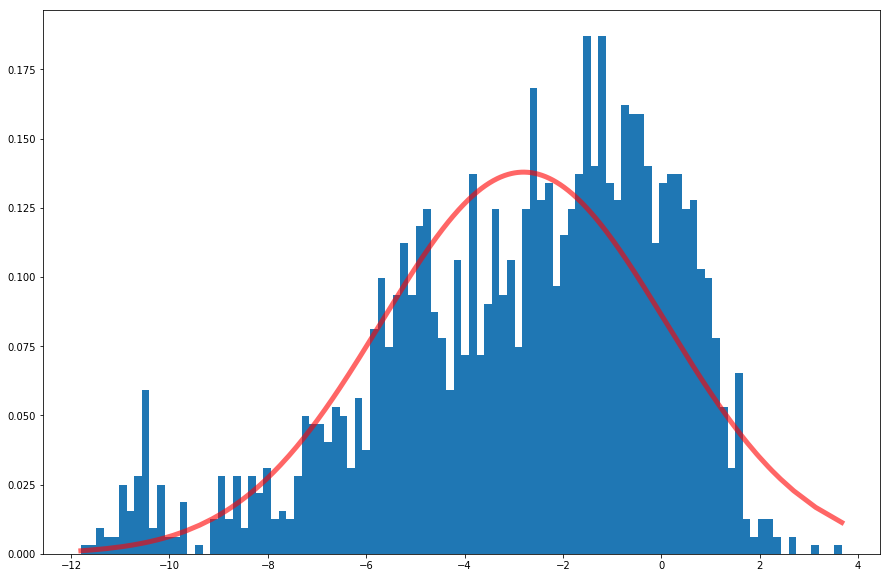

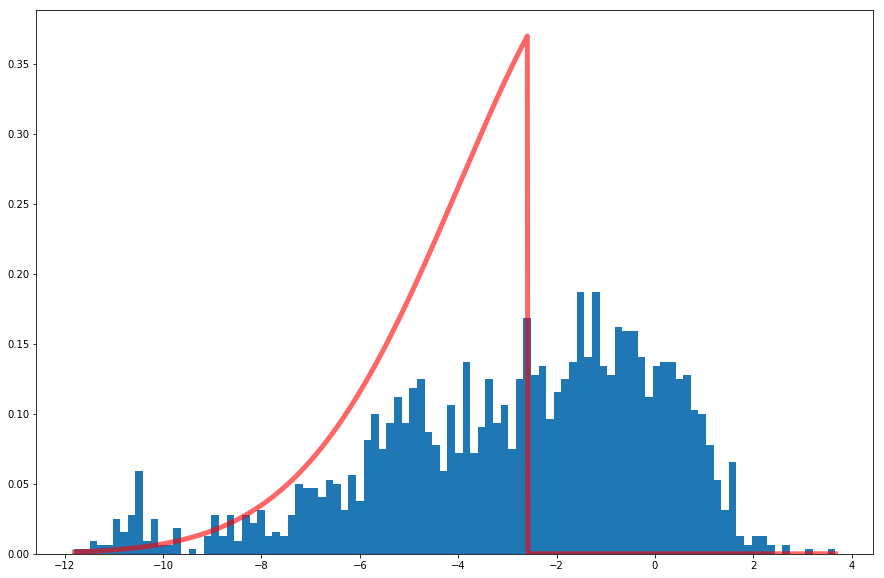

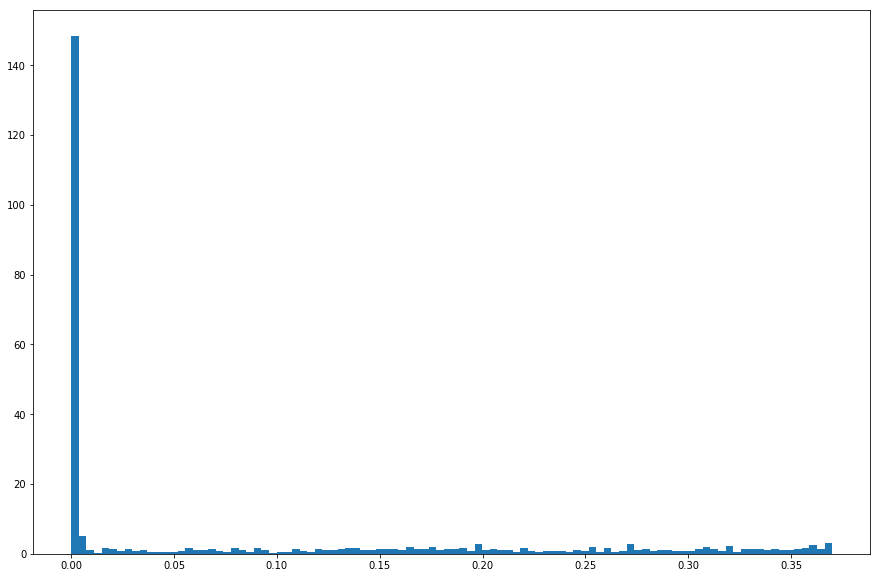

[0.00122614 0.00156523 0.00185869 ... 0.         0.         0.        ]
[0.50048916 0.50062444 0.50074151 ... 0.5        0.5        0.5       ]
0 pathways have p <= 0.001


In [17]:
pvalues = clusterframes['1']['p-values'].tolist()
z_scores = norm.ppf(pvalues)


xa = np.quantile(z_scores, 0.25)
xb = np.quantile(z_scores, 0.75)
print('quantiles calculated')
print(xa, xb)

trunc_z = z_scores[z_scores>xa]
trunc_z = trunc_z[trunc_z<xb]

def func(p, r, xa, xb):
    return truncnorm.nnlf(p, r)

def constraint(p, r, xa, xb):
    a, b, loc, scale = p
    return np.array([a*scale + loc - xa, b*scale + loc - xb])

loc = 0
scale = 1

a = (xa - loc)/scale
b = (xb - loc)/scale

loc_guess = 0
scale_guess = 1
a_guess = (xa - loc_guess)/scale_guess
b_guess = (xb - loc_guess)/scale_guess
p0 = [a_guess, b_guess, loc_guess, scale_guess]

par = fmin_slsqp(func, p0, f_eqcons=constraint, args=(trunc_z, xa, xb), iter=3000)
print(par)



fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.hist(z_scores, bins=100, density=True)
ax.plot(z_scores, norm.pdf(z_scores, mean, var), 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.hist(z_scores, bins=100, density=True)
ax.plot(z_scores, truncnorm.pdf(z_scores, xa, xb, par[2], par[3]), 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()



normal_Z = truncnorm.pdf(z_scores, xa, xb, par[2], par[3])
plt.figure(figsize=(15, 10))
plt.hist(normal_Z, bins=100, density=True)
plt.show()
print(normal_Z)
normal_p = norm.sf(-abs(normal_Z))
print(normal_p)

#how are the p-values ordered?



print(f'{(normal_p <= 0.001).sum()} pathways have p <= 0.001')